In [184]:
import os 
import pickle
from PIL import Image
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from torch import optim
import matplotlib.pyplot as plt

In [185]:
demo_dataloader = {}

In [186]:
class BiasedCarsDataset(Dataset):
    def __init__(self, root_dir, split, transform = None):
        self.root_dir = root_dir
        self.transform = transform 

        with open (os.path.join(root_dir, 'att_dict_simplified.p'), 'rb') as f: 
            self.labels = pickle.load(f)
        
        self.data = []
        for key in self.labels:
            img_path = os.path.join(root_dir, split, key)            
            if os.path.exists(img_path):
                self.data.append((img_path, self.labels[key][2]))
        demo_dataloader = self.data
        print(self.data)

    def __len__(self): 
        return len(self.data)
        
    def __getitem__ (self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform is not None: 
            img = self.transform(img)
        return img, label

In [187]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear (196608, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 10)
        self.do = nn.Dropout(0.1)
    
    def forward(self, x): 
        h1 = nn.functional.relu(self.l1(x))
        h2 = nn.functional.relu(self.l2(h1))
        do = self.do(h2 + h1)
        logits = self.l3(do)
        return logits

In [188]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

dataset = BiasedCarsDataset('/Users/ahiremath/Desktop/neuro240_deliverable2/biased_cars_1/', 'train', transform=transform)

model = ResNet()
loss = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr = 1e-2)

[('/Users/ahiremath/Desktop/neuro240_deliverable2/biased_cars_1/train/frame_0005_0_5_0622926_2020-02-02_3B0CGR4S.png', 1), ('/Users/ahiremath/Desktop/neuro240_deliverable2/biased_cars_1/train/frame_0005_0_5_0622938_2020-02-02_M4LXYJWW.png', 1), ('/Users/ahiremath/Desktop/neuro240_deliverable2/biased_cars_1/train/frame_0005_0_5_0622939_2020-02-02_M4LXYJWW.png', 1), ('/Users/ahiremath/Desktop/neuro240_deliverable2/biased_cars_1/train/frame_0005_0_5_0622940_2020-02-02_M4LXYJWW.png', 1), ('/Users/ahiremath/Desktop/neuro240_deliverable2/biased_cars_1/train/frame_0005_0_5_0622943_2020-02-02_M4LXYJWW.png', 1), ('/Users/ahiremath/Desktop/neuro240_deliverable2/biased_cars_1/train/frame_0005_0_5_0622950_2020-02-02_M4LXYJWW.png', 1), ('/Users/ahiremath/Desktop/neuro240_deliverable2/biased_cars_1/train/frame_0005_0_5_0622952_2020-02-02_M4LXYJWW.png', 1), ('/Users/ahiremath/Desktop/neuro240_deliverable2/biased_cars_1/train/frame_0005_0_5_0622953_2020-02-02_M4LXYJWW.png', 1), ('/Users/ahiremath/Desk

In [189]:
val_size = int(len(dataset) * 0.2)

train_size = len(dataset) - val_size

train, val = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train, batch_size = 32, shuffle = True)
val_loader = DataLoader(val, batch_size = 32, shuffle = True)

In [190]:
nb_epochs = 5
for epoch in range(nb_epochs):
    losses = list()
    for batch in train_loader:
        x, y = batch
        b = x.size(0)
        x = x.view(b, -1)

        logit = model(x)

        J = loss (logit, y)

        model.zero_grad()

        J.backward()

        optimiser.step()

        losses.append(J.item())

    print (f'Epoch {epoch + 1} - train loss: {torch.tensor(losses).mean():.3f}')
    
    losses = list()
    for batch in val_loader:
        x, y = batch
        b = x.size(0)
        x = x.view(b, -1)

        with torch.no_grad():
            logit = model(x)

        J = loss(logit,y)

        losses.append(J.item())

    print (f'Epoch {epoch + 1} - validation loss: {torch.tensor(losses).mean():.3f}\n')

Epoch 1 - train loss: 0.806
Epoch 1 - validation loss: 0.687

Epoch 2 - train loss: 0.199
Epoch 2 - validation loss: 0.425

Epoch 3 - train loss: 0.105
Epoch 3 - validation loss: 0.387

Epoch 4 - train loss: 0.089
Epoch 4 - validation loss: 0.280

Epoch 5 - train loss: 0.069
Epoch 5 - validation loss: 0.339



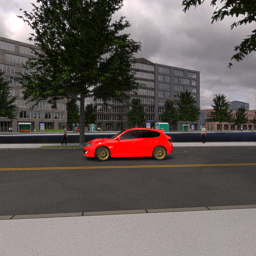

In [199]:
from IPython import display

# Printing images from the data we loaded in from our data uploader. I just took some random paths from what was printed above. Hope that's okay. 
display.Image("/Users/ahiremath/Desktop/neuro240_deliverable2/biased_cars_1/train/frame_0005_0_5_6210200_2020-04-06_H17L739H.png")

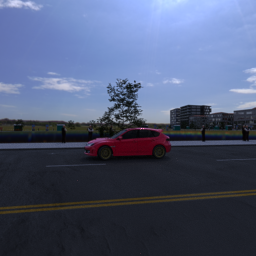

In [200]:
display.Image('/Users/ahiremath/Desktop/neuro240_deliverable2/biased_cars_1/train/frame_0005_0_5_6198676_2020-04-06_UMZMW1R8.png')

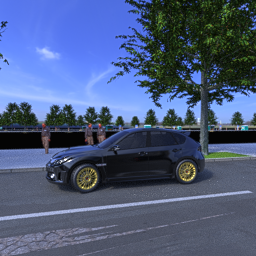

In [201]:
display.Image('/Users/ahiremath/Desktop/neuro240_deliverable2/biased_cars_1/train/frame_0005_0_5_6203725_2020-04-06_CIXPAOFY.png')

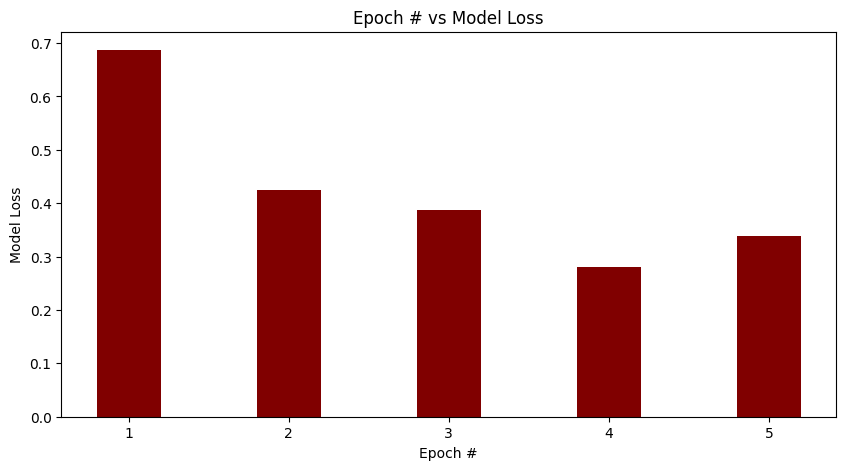

In [202]:
data = {'1':0.687, '2':0.425, '3':0.387,
        '4':0.280, '5':0.339}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Epoch #")
plt.ylabel("Model Loss")
plt.title("Epoch # vs Model Loss")
plt.show()